# Stock Forecasting

Create a RNN, and LSTM to make predicitons of closing prices for Nividia stock.

Compare each model using Regression Metrics: MSE, RMSE, MAE, R2, and see which performs better.

## Summary of Work

In this project, I implemented both a Recurrent Neural Network (RNN) and a Long Short-Term Memory (LSTM) model to predict Nvidia’s closing stock price. Historical price data was extracted from Yahoo Finance and split sequentially into training (60%), validation (20%), and testing (20%) sets to preserve temporal order, which is essential for sequence models.

The data was preprocessed using a log transformation followed by standardization (z-score) to reduce exponential growth and center the data around zero, improving model stability. Sliding windows were then created to convert the time series into sequences suitable for training, producing feature–target pairs for each dataset. A window size of 20 and a step size of 2 were used.

Both models were implemented in PyTorch using nn.Module, with identical architectures: input size of 1, hidden size of 8, and a single recurrent layer. Training was performed using the Adam optimizer and Mean Squared Error (MSE) loss over 10 epochs, with a batch size of 32 and a learning rate of 0.002. Validation loss was monitored during training to assess generalization and detect overfitting.

After training, the best-performing model (based on validation loss) was evaluated on a held-out test set. Performance was measured using MSE, RMSE, MAE, and R². As expected, the LSTM slightly outperformed the RNN, likely due to its ability to capture longer-term dependencies in the data.

Overall, this project deepened my understanding of sequence modeling and time-series forecasting, particularly the importance of chronological data handling and window-based feature construction. It was a valuable shift from traditional machine learning workflows and a strong foundation for more advanced forecasting models in the future..

## Results

As mentioned above, the models were tested using several regression metrics to allow for a proper comparison. The results for each model are shown below.

#### RNN

- MSE: 226.0
- RSME: 15.033
- MAE: 4.036
- R2: 0.816

#### LSTM

- MSE: 94.0
- RSME: 9.695
- MAE: 2.873
- R2: 0.924

Overall, the results suggest that for this simplified task of predicting closing stock prices, the LSTM outperforms the RNN. This is most clearly reflected in the RMSE, where the LSTM achieves an error of $9.695, compared to $15.033 for the RNN. This indicates that the LSTM’s predictions are, on average, closer to the true values, which aligns with its ability to capture longer-term temporal dependencies.

## Future Work

This was a challenging project that took longer than expected to fully understand the underlying concepts, which meant that some of the ideas I initially wanted to explore were left unfinished. In terms of future work, one clear improvement would be to incorporate additional input features and develop a multivariate RNN and LSTM instead of relying on a single variable. Since stock prices are often influenced by public sentiment, another interesting extension would be to include sentiment analysis in the model. For example, a pipeline could be built to track specific Twitter accounts, generate sentiment scores, and feed that information into the sequence models.

It would also be interesting to experiment with other sequence architectures, such as a GRU, and compare their performance against the RNN and LSTM. Beyond architecture changes, further hyperparameter tuning could be done to improve forecasting accuracy. Another possible direction would be to focus on next-day predictions and evaluate how well the models perform in a more realistic setting, potentially even creating a pipeline that continuously ingests new data and updates the model over time. Overall, there are many possible extensions to this project, and it highlights how much potential there is in building more sophisticated stock forecasting models. Hopefully I will be able to return to this project and develop many of these potential improvements.

# Data Splitting and Transforming

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import torch

from data_handler import (
    extract_stock_close_price,
    inverse_transform,
    log_transformation,
    sliding_window,
    split_data,
    split_feature_targets,
    standardization,
)
from sequence_model import (
    SimpleLSTM,
    SimpleRNN,
    calculate_regression_metrics,
    test_model,
    train_model,
)


In [ ]:
# Extract data, split, and transform it

file = "data/nvidia_stock_price_max_hist.csv"
close_raw = extract_stock_close_price("NVDA", "max", file, "Close")

test_ratio = 0.20
train_temp, test_raw = split_data(close_raw, test_ratio)

val_ratio = 0.20
train_raw, val_raw = split_data(train_temp, val_ratio)

train_log = log_transformation(train_raw)
train_clean, train_log_mean, train_log_std = standardization(train_log)

val_log = log_transformation(val_raw)
val_clean = (val_log - train_log_mean) / train_log_std

test_log = log_transformation(test_raw)
test_clean = (test_log - train_log_mean) / train_log_std

In [ ]:
# Create sliding window from transformed data and generate final dataset

window_size = 20
window_step = 2
val_ratio = 0.20

train_set = sliding_window(train_clean, window_size, window_step)
X_train, y_train = split_feature_targets(train_set)

val_set = sliding_window(val_clean, window_size, window_step)
X_val, y_val = split_feature_targets(val_set)

test_set = sliding_window(test_clean, window_size, window_step)
X_test, y_test = split_feature_targets(test_set)

# RNN

In [ ]:
# Train model

rnn = SimpleRNN()
num_epochs=10
batch_size=32
learning_rate=0.002
rnn_train_loss, rnn_val_loss, (best_rnn_model, best_rnn_epoch) = train_model(
    rnn, num_epochs, batch_size, learning_rate, X_train, y_train, X_val, y_val,
)

Epoch 1
Train loss: 0.8258110338544665
Val Loss: 0.6274761071099955
Epoch 2
Train loss: 0.21210885049624587
Val Loss: 0.13154743228326826
Epoch 3
Train loss: 0.08723353383624378
Val Loss: 0.0576935556361123
Epoch 4
Train loss: 0.053048638486549914
Val Loss: 0.039530681966639614
Epoch 5
Train loss: 0.03451125233593356
Val Loss: 0.027033952283946908
Epoch 6
Train loss: 0.02698382187030374
Val Loss: 0.020955795750898475
Epoch 7
Train loss: 0.02106353314679034
Val Loss: 0.01685236382079037
Epoch 8
Train loss: 0.01746756056416095
Val Loss: 0.014470635201124585
Epoch 9
Train loss: 0.014680371391638318
Val Loss: 0.012749771779293524
Epoch 10
Train loss: 0.012630639347395011
Val Loss: 0.011591373805833213


In [ ]:
# Save best model

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(
    best_rnn_model.state_dict(),
    f"saved_models/rnn_model_epoch_{best_rnn_epoch}_daytime_{timestamp}.pt",
)

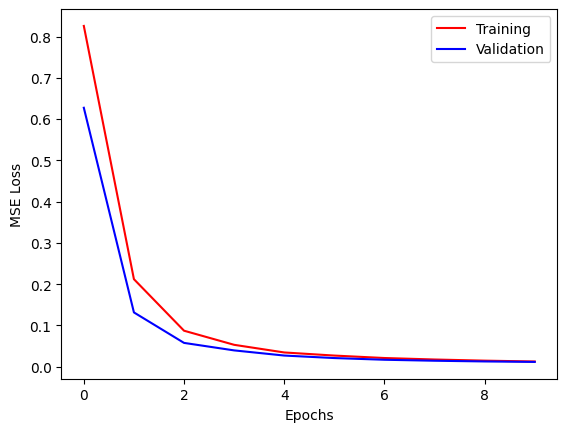

In [ ]:
# Plot train and validation curves

epochs = [*range(num_epochs)]
plt.plot(epochs, rnn_train_loss, label="Training", color="red")
plt.plot(epochs, rnn_val_loss, label="Validation", color="blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [ ]:
# Load and test best model

rnn_file = "saved_models/rnn_model_epoch_10_daytime_20251221_062219.pt"
rnn_state_dict = torch.load(rnn_file)
best_rnn_model.load_state_dict(rnn_state_dict)

rnn_pred = test_model(best_rnn_model, X_test, y_test)

inverse_rnn_pred = inverse_transform(rnn_pred, train_log_mean, train_log_std)
y_true = inverse_transform(y_test, train_log_mean, train_log_std)

MSE, RMSE, MAE, R2 = calculate_regression_metrics(inverse_rnn_pred, y_true)

In [ ]:
# Regression Metrics

print(f"MSE: {MSE}")
print(f"RSME: {RMSE}")
print(f"MAE: {MAE}")
print(f"R2: {R2}")

MSE: 226.0
RSME: 15.033
MAE: 4.036
R2: 0.816


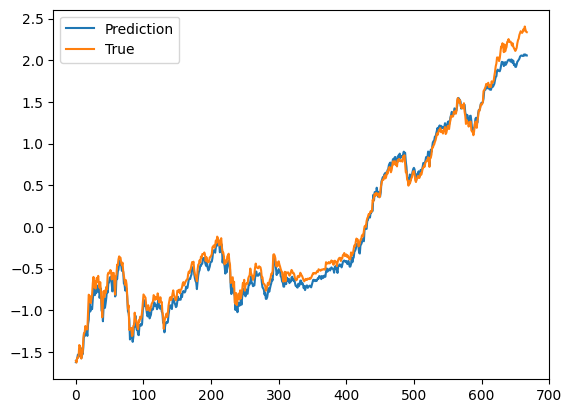

In [ ]:
# Predictions vs Actual values in test set (transformed data)

plt.plot(rnn_pred, label="Prediction")
plt.plot(y_test, label="True")
plt.legend()

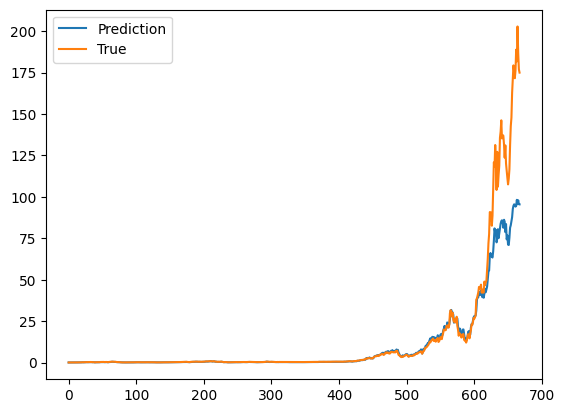

In [ ]:
# Predictions vs Actual values in test set

plt.plot(inverse_rnn_pred, label="Prediction")
plt.plot(y_true, label="True")
plt.legend()

# LSTM

In [ ]:
# Train Model

lstm = SimpleLSTM()
num_epochs=10
batch_size=32
learning_rate=0.002
lstm_train_loss, lstm_val_loss, (best_lstm_model, best_lstm_epoch) = train_model(
    lstm, num_epochs, batch_size, learning_rate, X_train, y_train, X_val, y_val,
)

Epoch 1
Train loss: 1.041244082043276
Val Loss: 0.8178627821890747
Epoch 2
Train loss: 0.5530266428540926
Val Loss: 0.3929735383785823
Epoch 3
Train loss: 0.23347537654712247
Val Loss: 0.2017667639781447
Epoch 4
Train loss: 0.14779078416990266
Val Loss: 0.1377311589963296
Epoch 5
Train loss: 0.09309795312583447
Val Loss: 0.08135559575577431
Epoch 6
Train loss: 0.053149371418198026
Val Loss: 0.050156943020684755
Epoch 7
Train loss: 0.03437004393323578
Val Loss: 0.03631123987382606
Epoch 8
Train loss: 0.023792882338645596
Val Loss: 0.02939382818637087
Epoch 9
Train loss: 0.016592735680794304
Val Loss: 0.020408923655529234
Epoch 10
Train loss: 0.010623405190391863
Val Loss: 0.012016804505358724


In [ ]:
# Save best model

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(
    best_lstm_model.state_dict(),
    f"saved_models/lstm_model_epoch_{best_lstm_epoch}_daytime_{timestamp}.pt",
)

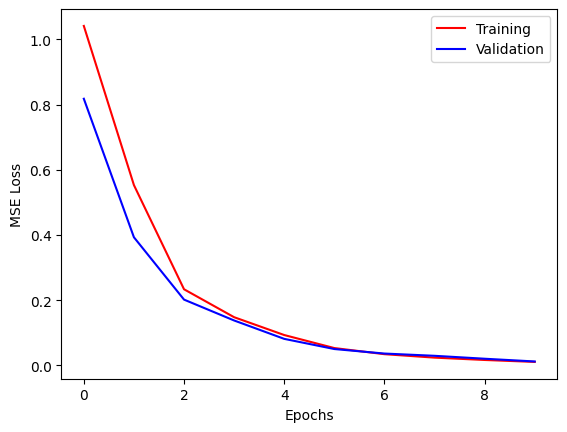

In [ ]:
# Plot train and validation curves

epochs = [*range(num_epochs)]
plt.plot(epochs, lstm_train_loss, label="Training", color="red")
plt.plot(epochs, lstm_val_loss, label="Validation", color="blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [ ]:
# Load and test best model

lstm_file = "saved_models/lstm_model_epoch_10_daytime_20251221_062341.pt"
lstm_state_dict = torch.load(lstm_file)
best_lstm_model.load_state_dict(lstm_state_dict)

lstm_pred = test_model(best_lstm_model, X_test, y_test)

inverse_lstm_pred = inverse_transform(lstm_pred, train_log_mean, train_log_std)
y_true = inverse_transform(y_test, train_log_mean, train_log_std)

MSE, RMSE, MAE, R2 = calculate_regression_metrics(inverse_lstm_pred, y_true)

In [ ]:
# Regression Metrics

print(f"MSE: {MSE}")
print(f"RSME: {RMSE}")
print(f"MAE: {MAE}")
print(f"R2: {R2}")

MSE: 94.0
RSME: 9.695
MAE: 2.873
R2: 0.924


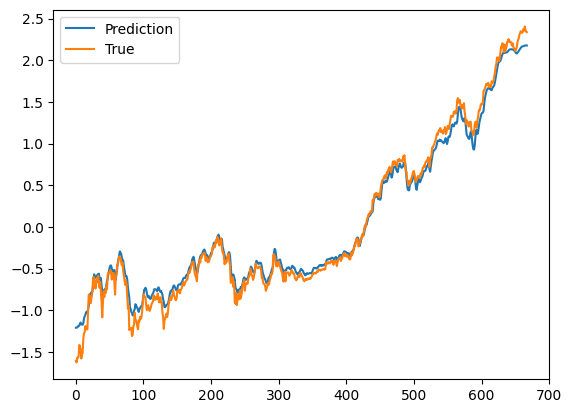

In [ ]:
# Predictions vs Actual values in test set (transformed data)

plt.plot(lstm_pred, label="Prediction")
plt.plot(y_test, label="True")
plt.legend()

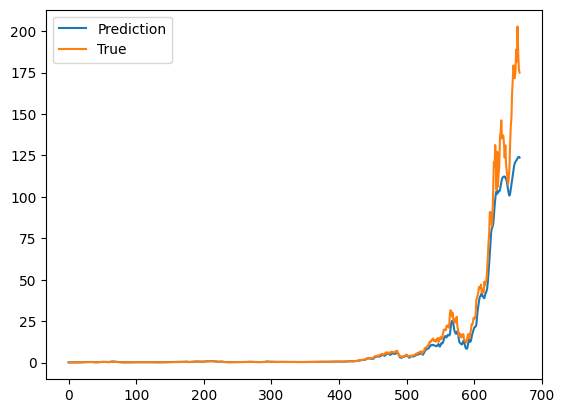

In [ ]:
# Predictions vs Actual values in test set

plt.plot(inverse_lstm_pred, label="Prediction")
plt.plot(y_true, label="True")
plt.legend()